In [1]:
%matplotlib inline
# load the autoreload extension
%load_ext autoreload
# autoreload mode 2, which loads imported modules again 
# everytime they are changed before code execution.
# So we don't need to restart the kernel upon changes to modules
%autoreload 2

In [2]:
!pip install --upgrade typing
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

     |████████████████████████████████| 78 kB 24.4 MB/s eta 0:00:01
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26305 sha256=78d76c72e0ecbb1aefdcf21fbab1ed8f2d71fc2a6af7de083312a3341646d460
  Stored in directory: /root/.cache/pip/wheels/5e/5d/01/3083e091b57809dad979ea543def62d9d878950e3e74f0c930
Successfully built typing
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
Could not fetch URL https://download.pytorch.org/whl/cu117/torch/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='download.pytorch.org', port=443): Max retries exceeded with url: /whl/cu117/torch/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1131)'))) - skipping
     |█████████████                   | 323.1 MB 130.0 MB/s eta 0:00:04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |█████████████████████████████▍  | 731.5 MB 140.9 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Could not fetch URL https://download.pytorch.org/whl/cu117/torchvision/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='download.pytorch.org', port=443): Max retries exceeded with url: /whl/cu117/torchvision/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1131)'))) - skipping
     |████████████████████████████████| 7.0 MB 118.5 MB/s eta 0:00:01
Could not fetch URL https://download.pytorch.org/whl/cu117/torchaudio/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='download.pytorch.org', port=443): Max retries exceeded with url: /whl/cu117/torchaudio/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1131)'))) - skipping
     |████████████████████████████████| 3.4 MB 105.7 MB/s eta 0:00:01
Could not fetch URL https://download.pytorch.org/whl/cu117/nvidia-cusparse-cu12/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='download.pytorch

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |██████████████████████▋         | 468.8 MB 139.5 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 664.8 MB 35 kB/s 
Could not fetch URL https://download.pytorch.org/whl/cu117/networkx/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='download.pytorch.org', port=443): Max retries exceeded with url: /whl/cu117/networkx/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1131)'))) - skipping
     |████████████████████████████████| 2.1 MB 100.7 MB/s eta 0:00:01
Could not fetch URL https://download.pytorch.org/whl/cu117/nvidia-cufft-cu12/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='download.pytorch.org', port=443): Max retries exceeded with url: /whl/cu117/nvidia-cufft-cu12/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1131)'))) - skipping
     |████████████████████████████████| 121.6 MB 308 kB/s s eta 0:00:01
Could not fetch URL https://download.pytorch.org/whl/cu117/filelock/: There was a problem confirming the ssl

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn #CUDA Deep Neural Network Library
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory

from PIL import Image
cudnn.benchmark = True
plt.ion()
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
DATA_DIR='./data'
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
transform_train = transforms.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5), #flip given a probability
    v2.ToImage(), # only needed if you have an PIL image
    v2.ToDtype(torch.float32, scale=True), #Normalize expects float input. scale the value?
    v2.Normalize(mean, std), #normalize with CIFAR mean and std
])
test_train = transforms.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #Normalize expects float input. scale the value?
    v2.Normalize(mean, std), #normalize with CIFAR mean and std
])
train_data = torchvision.datasets.CIFAR10(root=DATA_DIR, train = True, transform = transform_train, download = True)
test_data = torchvision.datasets.CIFAR10(root=DATA_DIR, train = False, transform = test_train, download = True)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False, num_workers=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

Files already downloaded and verified
Files already downloaded and verified
device:  cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.754760736716321e-08..0.9686275165081024].


shape:  (32, 32, 3)
shape:  (32, 32, 3)
shape:  (32, 32, 3)
shape:  (32, 32, 3)


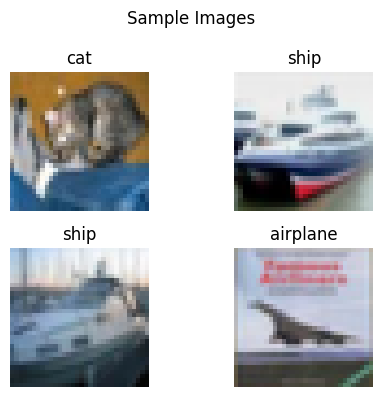

In [5]:
class_names = train_data.classes
def denorm(img):
    m = np.array(mean)
    s = np.array(std)
    img = img.numpy() * s + m
    return img

ROWS, CLM=2, 2
fig, axes = plt.subplots(nrows=ROWS, ncols=CLM)
fig.suptitle('Sample Images')
features, labels=next(iter(test_dataloader))
for i, ax in enumerate(axes.flat):
    img = denorm(features[i].permute(1,2,0).squeeze())
    print("shape: ", img.shape)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(class_names[labels[i].item()])
plt.tight_layout()
plt.imshow(img)

- `loss.item()` gives the average loss across the current batch
- `model.eval()` and `model.train()`?

In [20]:
# model = models.resnet50(weights='IMAGENET1K_V1') # This is close to the training result in paper. V2 is better
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 10)
# model = model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# # Decay learning rate by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [6]:
def conv_3x3(in_channels, out_channels, stride, padding):
    return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            padding=padding,
            bias=False,
        )
    
def conv_1x1(in_channels, out_channels, stride):
    return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=stride,
            padding=0,
            bias=False,
        )
     
class BasicIdentityBlock(nn.Module):
    """This is not the bottleneck block, it's the basic identity block
    Basic means there are 2 convolutions (3x3) back to back
    Identity means the skip connection does not require 1x1 convolution for reshaping 
    """
    def __init__(self, in_channels, out_channels, stride) -> None:
        # first conv layer is in charge of the actual stride
        super().__init__()
        self.conv1 = conv_3x3(in_channels=in_channels, 
                              out_channels=out_channels, stride=stride, padding=1,)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # second conv does same convolution
        self.conv2 = conv_3x3(in_channels=out_channels, 
                              out_channels=out_channels, stride=1, padding=1,)
        
        self.bn2 = nn.BatchNorm2d(out_channels)
        # since this is identity, we can add outputs with inputs together, if stride is 1
        if stride != 1:
            # this is downsampling. Downsampling in ResNet is done thru conv layer 
            self.short_cut = nn.Sequential(
                conv_1x1(in_channels=in_channels, out_channels=out_channels, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.short_cut = nn.Identity()

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        short_cut = self.short_cut(x)
        out += short_cut
        out = self.relu(out)
        return out
        

class ResNetCIFAR(nn.Module):
    def __init__(self, block, num_blocks, num_classes) -> None:
        # input_shape = (64, 64, 3)
        super().__init__()
        # same padding, output 32x32x16
        output_channels = [16, 16, 32, 64]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=output_channels[0], kernel_size=(3, 3), stride=1,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=output_channels[0])
        # 32x32x16
        self.layer0 = self._make_layer(block, num_blocks[0], in_channels = output_channels[0], out_channels=output_channels[1], stride=1)  
        # 16x16x32
        self.layer1 = self._make_layer(block, num_blocks[1], in_channels = output_channels[1], out_channels=output_channels[2], stride=2)  # 16x16
        # 8x8x64
        self.layer2 = self._make_layer(block, num_blocks[2], in_channels = output_channels[2], out_channels=output_channels[3], stride=2)  # 8x8
        self.relu=nn.ReLU(inplace=True)
        # output 1x1x64
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_features=output_channels[3], out_features=num_classes)   #10

        self._initialize_weights()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def _make_layer(self, block, num_block, in_channels, out_channels, stride):
        # first block may downsample
        layers = [
            block(in_channels, out_channels=out_channels, stride=stride)
        ]
        for _ in range(num_block-1):
            layers.append(block(in_channels=out_channels, out_channels=out_channels, stride=1))
        return nn.Sequential(*layers)
            
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

# resnet-20
model = ResNetCIFAR(block=BasicIdentityBlock, num_blocks=[3,3,3], num_classes=len(train_data.classes))
input_tensor_test = torch.randn(1,3,32,32)
output = model(input_tensor_test)
print(output.shape)

torch.Size([1, 10])


In [8]:
import time
# Define the training function
MODEL_PATH = 'resnet_cifar10.pth'
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        start = time.time()

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
#             print(1)
            outputs = model(inputs)
#             print(2)

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
#             print(3)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100. * correct_train / total_train

        torch.save(model.state_dict(), MODEL_PATH)
        print(f"epoch: {epoch}, saved the model")
        # Evaluation phase
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs_test, labels_test in test_loader:
                inputs_test = inputs_test.to(device)
                labels_test = labels_test.to(device)
                outputs_test = model(inputs_test)
                _, predicted_test = outputs_test.max(1)
                total_test += labels_test.size(0)
                correct_test += predicted_test.eq(labels_test).sum().item()

        test_acc = 100. * correct_test / total_test

        # Adjust learning rate
        scheduler.step()
        end = time.time()
        print("elapsed: ", end-start)

        print(f'Epoch [{epoch + 1}/{num_epochs}] '
              f'Train Loss: {epoch_loss:.4f} '
              f'Train Acc: {epoch_acc:.2f}% '
              f'Test Acc: {test_acc:.2f}%')

    print('Training complete')
    return model

In [13]:
import os


criterion = nn.CrossEntropyLoss()
weight_decay = 0.0001
momentum=0.9
learning_rate=0.1
num_epochs=200
batch_size=16
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)

# Train the model
model.load_state_dict(torch.load(MODEL_PATH, weights_only=False, map_location=device))
model.to(device)
# On a single Nvidia A10G GPU, an epoch takes ~170s
model = train_model(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler,
                    num_epochs=num_epochs, device=device)



RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.